In [107]:
from game_of_life import Game_of_life
from autoencoder import ConvolutionalAutoencoder
from fullycon import CullyConnCoder

import torch.nn as nn
import torch
import tqdm
import torch.optim as optim
import copy

# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

SIZE=16
SIM_BATHC = 6
ADVANCED_ENEI_PARAM = 0.0002 # THE LAN REGULARIZATION PARAMETER
ENEIAN_BIASING = 0.3

def generate_batch(batch_size, size, sims=SIM_BATHC, n_plus = 1, bias=0.5):
    with torch.no_grad():
        game = Game_of_life(size)
        game.to(device)
        # random binary noise of size size x size
        prev_batch = torch.rand((batch_size, 1, size, size), device=device)
        prev_batch = (prev_batch > bias).int()
        batch = game(prev_batch)

        for i in range(sims):
            batch, prev_batch = game(batch), batch

        for i in range(1, n_plus):
            batch = game(batch)

        return prev_batch, batch


def cell_count_MSE(outputs, labels, input):
    # count of dead cells in the output
    output_alive_cells = torch.sum(input == 1, dim=(1,2,3)).float()
    alive_cells = torch.sum(outputs == 1, dim=(1,2,3)).float()
    dead_cells = torch.sum(outputs == 0, dim=(1,2,3)).float()

    log_dead_cell  = torch.mean(torch.log(alive_cells / dead_cells + 1)) / (SIZE*SIZE)
    # step_diff = torch.mean(input - outputs) # ADVANCED_ENEI_PARAM
    # lanoid_fraction = torch.mean(torch.abs(alive_cells - output_alive_cells)) / (SIZE*SIZE)

    mse_loss = nn.MSELoss()(outputs, labels)

    loss = torch.add(mse_loss, ADVANCED_ENEI_PARAM * log_dead_cell )
    return loss

def train_model(epochs, lr=0.001, decay=0, lr_decay=1e-5):
    # Use the ResNet18 when implemented
    # net = ConvolutionalAutoencoder(SIZE)
    net = CullyConnCoder(SIZE)
    net.to(device)
    net.train()

    game = Game_of_life(SIZE)
    game.to(device)

    # Define the loss function
    # criterion = nn.BCELoss(reduction='mean') 
    criterion = nn.MSELoss()
    # criterion = cell_count_MSE

    # criterion = nn.CrossEntropyLoss()
    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay, eps=lr_decay)

    losses = [20000]
    best_model = None
    # loss_ra = 0
    for epoch in tqdm.tqdm(range(epochs)):
        # Get the inputs; Data is a tuple of (images, labels)
        inputs, labels = generate_batch(200, SIZE, SIM_BATHC, 2, ENEIAN_BIASING)

        
        # for i in range(5):
        # Clear the saved gradients of the previous iteration
        optimizer.zero_grad()
        outputs = net(inputs)
        # print(torch.min(outputs[0]), torch.max(outputs[0]))
        
        # # Calculate the loss value
        loss = criterion(outputs.float(), labels.float())
        if torch.min(torch.FloatTensor(losses).to(device)) > loss:
            torch.save(net, 'model.pt')
            # print('saved')
        losses.append(loss.data.cpu().detach().numpy())
        

        # # Calculate the gradients using backpropagation
        loss.backward()
        # loss_ra += loss.data.cpu().detach().numpy()
        # # Update the weights of the network using the chosen optimizer
        # if epoch % 100 == 0:
        #     print(outputs[0].detach().cpu().numpy())
        # new_state = outputs.detach() < 0.5 
        # inputs = new_state.float()
        # labels = game(new_state).float()
        
        optimizer.step()
        

        if (epoch % 100) == 0:
            # print(torch.sum(outputs[0] - labels[0]))
            print(loss.data.cpu().detach().numpy())
            # lr /= 1.1


    # net.eval()
    # test_bird_model(net,testloader)
    net = torch.load('./model.pt')
    net.eval()
    return net, losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import matplotlib.pyplot as plt
# torch.cuda.empty_cache()

net,losses = train_model(8000, lr=0.013, decay=0, lr_decay=1e-5)
# prosim delaj



  0%|          | 16/8000 [00:00<02:52, 46.30it/s]

0.04317253


  2%|▏         | 126/8000 [00:01<00:58, 134.74it/s]

0.019394107


  3%|▎         | 220/8000 [00:01<00:51, 149.87it/s]

0.018657777


  4%|▍         | 323/8000 [00:02<00:59, 129.06it/s]

0.013818774


  5%|▌         | 427/8000 [00:03<00:54, 139.90it/s]

0.013754028


  6%|▋         | 517/8000 [00:04<00:53, 139.80it/s]

0.025785774


  8%|▊         | 622/8000 [00:04<00:56, 130.10it/s]

0.0069973604


  9%|▉         | 720/8000 [00:05<01:07, 107.76it/s]

8.125923e-06


 10%|█         | 823/8000 [00:06<00:56, 126.90it/s]

1.969689e-06


 12%|█▏        | 923/8000 [00:07<00:51, 137.21it/s]

5.70236e-07


 13%|█▎        | 1020/8000 [00:08<00:53, 129.49it/s]

4.1168894e-07


 14%|█▍        | 1120/8000 [00:08<00:49, 140.09it/s]

1.458224e-07


 15%|█▌        | 1227/8000 [00:09<00:47, 141.71it/s]

4.266827e-08


 17%|█▋        | 1328/8000 [00:10<00:48, 137.63it/s]

3.8818012e-08


 18%|█▊        | 1418/8000 [00:11<00:45, 144.42it/s]

1.9846293e-08


 19%|█▉        | 1524/8000 [00:11<00:45, 143.58it/s]

2.2519082e-09


 20%|██        | 1615/8000 [00:12<00:44, 143.69it/s]

5.334024e-09


 22%|██▏       | 1722/8000 [00:13<00:42, 147.61it/s]

1.1862955e-09


 23%|██▎       | 1829/8000 [00:13<00:42, 144.88it/s]

9.142463e-11


 24%|██▍       | 1921/8000 [00:14<00:40, 149.50it/s]

6.092235e-10


 25%|██▌       | 2026/8000 [00:15<00:41, 145.60it/s]

2.6006589e-10


 26%|██▋       | 2116/8000 [00:15<00:40, 143.71it/s]

1.8734234e-10


 28%|██▊       | 2222/8000 [00:16<00:40, 141.03it/s]

1.03183524e-10


 29%|██▉       | 2324/8000 [00:17<00:41, 136.21it/s]

1.6576561e-11


 30%|███       | 2424/8000 [00:18<00:41, 135.18it/s]

3.173823e-10


 32%|███▏      | 2524/8000 [00:18<00:40, 134.53it/s]

1.0249229e-11


 33%|███▎      | 2623/8000 [00:19<00:39, 135.88it/s]

7.7999766e-11


 34%|███▍      | 2724/8000 [00:20<00:38, 136.68it/s]

3.4769826e-11


 35%|███▌      | 2824/8000 [00:21<00:38, 135.97it/s]

2.4225682e-12


 37%|███▋      | 2925/8000 [00:21<00:37, 135.39it/s]

4.8544675e-13


 38%|███▊      | 3028/8000 [00:22<00:35, 139.36it/s]

4.8868054e-12


 39%|███▉      | 3114/8000 [00:23<00:38, 125.67it/s]

8.399526e-12


 40%|████      | 3225/8000 [00:24<00:36, 129.20it/s]

1.3281083e-11


 42%|████▏     | 3321/8000 [00:24<00:35, 133.52it/s]

1.5188873e-12


 43%|████▎     | 3421/8000 [00:25<00:33, 138.06it/s]

1.1921036e-12


 44%|████▍     | 3526/8000 [00:26<00:30, 144.78it/s]

9.722171e-13


 45%|████▌     | 3616/8000 [00:26<00:30, 144.18it/s]

6.7040527e-12


 47%|████▋     | 3721/8000 [00:27<00:29, 143.41it/s]

1.8221536e-16


 48%|████▊     | 3826/8000 [00:28<00:29, 141.72it/s]

1.0933476e-14


 49%|████▉     | 3916/8000 [00:29<00:28, 143.60it/s]

4.068428e-12


 50%|█████     | 4021/8000 [00:29<00:28, 142.08it/s]

7.758768e-12


 52%|█████▏    | 4126/8000 [00:30<00:27, 142.51it/s]

8.915473e-13


 53%|█████▎    | 4216/8000 [00:31<00:26, 141.05it/s]

7.330264e-13


 54%|█████▍    | 4321/8000 [00:31<00:26, 141.35it/s]

3.6733854e-12


 55%|█████▌    | 4423/8000 [00:32<00:26, 137.24it/s]

1.5334993e-13


 57%|█████▋    | 4523/8000 [00:33<00:24, 139.29it/s]

3.13331e-14


 58%|█████▊    | 4622/8000 [00:34<00:25, 132.23it/s]

1.1747847e-12


 59%|█████▉    | 4722/8000 [00:34<00:24, 135.57it/s]

2.6577167e-12


 60%|██████    | 4818/8000 [00:35<00:25, 126.24it/s]

1.0647101e-13


 62%|██████▏   | 4928/8000 [00:36<00:23, 133.40it/s]

1.7938122e-13


 63%|██████▎   | 5027/8000 [00:37<00:22, 130.15it/s]

3.2741425e-12


 64%|██████▍   | 5121/8000 [00:37<00:23, 122.28it/s]

9.071216e-16


 65%|██████▌   | 5219/8000 [00:38<00:20, 133.41it/s]

8.7041756e-13


 66%|██████▋   | 5317/8000 [00:39<00:20, 129.42it/s]

2.7400305e-15


 68%|██████▊   | 5425/8000 [00:40<00:20, 125.50it/s]

4.063694e-15


 69%|██████▉   | 5524/8000 [00:40<00:17, 138.11it/s]

1.9166918e-13


 70%|███████   | 5624/8000 [00:41<00:17, 139.48it/s]

2.733369e-15


 72%|███████▏  | 5723/8000 [00:42<00:16, 137.42it/s]

6.1625704e-15


 73%|███████▎  | 5825/8000 [00:43<00:15, 139.43it/s]

3.0512813e-13


 74%|███████▍  | 5925/8000 [00:43<00:15, 138.26it/s]

6.692459e-14


 75%|███████▌  | 6024/8000 [00:44<00:14, 138.52it/s]

9.845631e-14


 77%|███████▋  | 6124/8000 [00:45<00:13, 139.05it/s]

1.124878e-14


 78%|███████▊  | 6222/8000 [00:46<00:12, 137.43it/s]

2.2300827e-13


 79%|███████▉  | 6320/8000 [00:46<00:12, 135.95it/s]

2.4420465e-14


 80%|████████  | 6418/8000 [00:47<00:12, 130.12it/s]

4.0731307e-15


 81%|████████▏ | 6517/8000 [00:48<00:11, 129.83it/s]

2.6911806e-15


 83%|████████▎ | 6622/8000 [00:49<00:11, 123.13it/s]

2.5798808e-14


 84%|████████▍ | 6715/8000 [00:49<00:10, 124.72it/s]

6.2549965e-15


 85%|████████▌ | 6821/8000 [00:50<00:09, 127.71it/s]

7.072121e-14


 87%|████████▋ | 6927/8000 [00:51<00:08, 126.53it/s]

1.5244056e-15


 88%|████████▊ | 7020/8000 [00:52<00:08, 117.43it/s]

7.499362e-14


 89%|████████▉ | 7127/8000 [00:53<00:06, 128.30it/s]

2.6600943e-15


 90%|█████████ | 7224/8000 [00:53<00:05, 134.82it/s]

6.403211e-16


 92%|█████████▏| 7322/8000 [00:54<00:05, 130.70it/s]

1.687539e-14


 93%|█████████▎| 7420/8000 [00:55<00:04, 133.92it/s]

1.45009e-14


 94%|█████████▍| 7517/8000 [00:56<00:03, 132.90it/s]

2.5424539e-12


 95%|█████████▌| 7615/8000 [00:56<00:02, 132.76it/s]

1.9028454e-07


 97%|█████████▋| 7722/8000 [00:57<00:02, 130.71it/s]

3.1371908e-07


 98%|█████████▊| 7819/8000 [00:58<00:01, 132.37it/s]

1.984729e-11


 99%|█████████▉| 7924/8000 [00:59<00:00, 121.20it/s]

1.5255799e-06


100%|██████████| 8000/8000 [00:59<00:00, 133.36it/s]


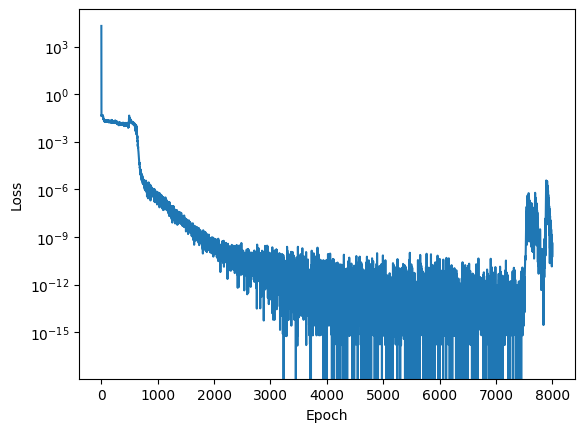

In [109]:
# Plot logaritmic loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

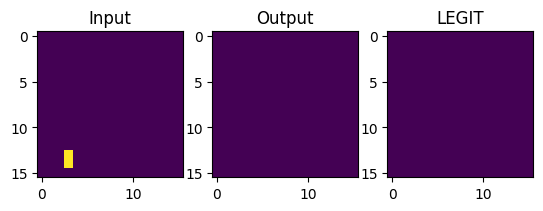

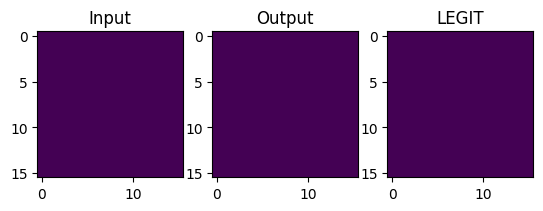

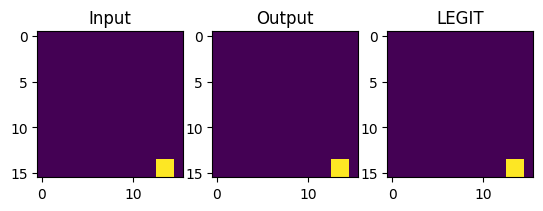

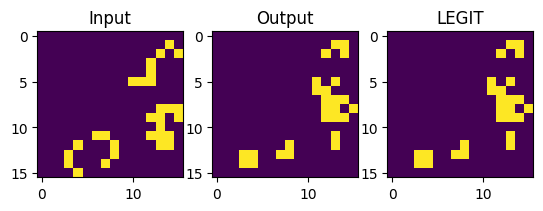

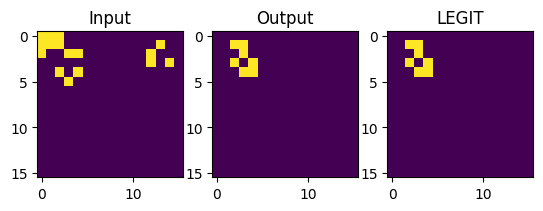

In [112]:
#RANDOM TRIES
batch, next= generate_batch(5, SIZE, SIM_BATHC, 2, ENEIAN_BIASING)
out = net(batch).cpu().detach().numpy()
# out = out > 0.5
ba = batch.cpu().detach().numpy()
ne = next.cpu().detach().numpy()

for i in range(5):
    ins = ba[i][0]
    res = out[i][0]
    nes = ne[i][0]
    fix, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(ins)
    ax1.set_title("Input")
    ax2.imshow(res)
    ax2.set_title("Output")
    ax3.imshow(nes)
    ax3.set_title("LEGIT")


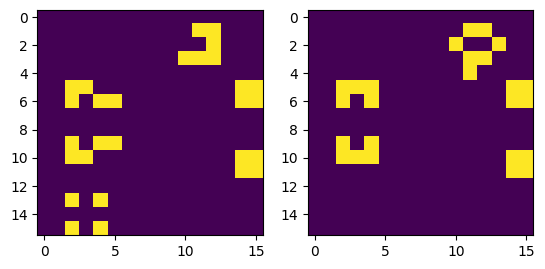

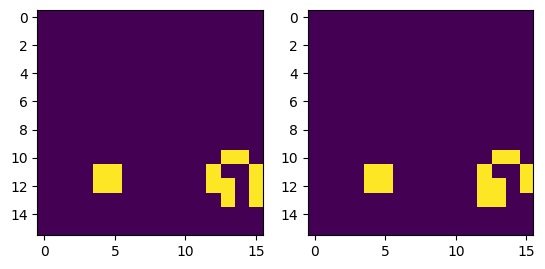

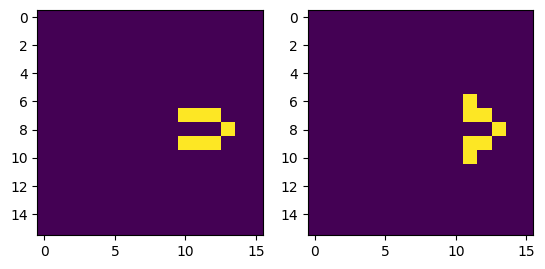

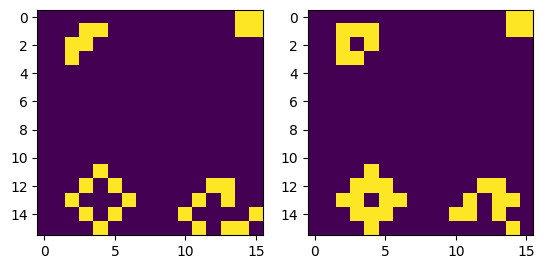

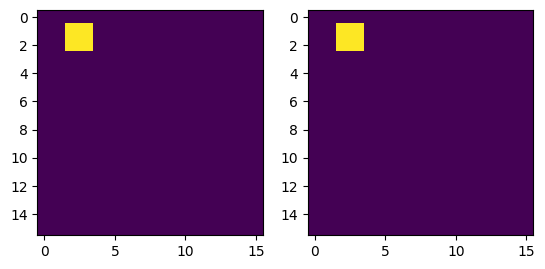

In [29]:
L = 5
out = generate_batch(L, SIZE, SIM_BATHC, 1, 0.3)
for i in range(L):
    ins = out[0][i][0].cpu().detach().numpy()
    res = out[1][i][0].cpu().detach().numpy()
    fix, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ins)
    ax2.imshow(res)

In [89]:
import pygame
SIZE = 256
GAME_SIZE = 4
WAIT = 20

calc_wait =round( WAIT / SIZE**0.5 ) 

def get_new(previous:torch.Tensor, net:torch.nn.Module):
    with torch.no_grad():
        tensor = net(previous)
        return tensor, tensor.squeeze().cpu().detach().numpy() > 0.5

def display_grid(grid, screen):
    size = len(grid)
    cell_size = GAME_SIZE
    for i in range(size):
        for j in range(size):
            if grid[i][j] == 1:
                pygame.draw.rect(screen, (255, 255, 255), (i*cell_size, j*cell_size, cell_size, cell_size))
            else:
                pygame.draw.rect(screen, (0, 0, 0), (i*cell_size, j*cell_size, cell_size, cell_size))
    pygame.display.flip()

first, second = generate_batch(1, SIZE, 15, 1, ENEIAN_BIASING)
tensor, grid = get_new(first, net)
pygame.init()
screen = pygame.display.set_mode((SIZE*GAME_SIZE, SIZE*GAME_SIZE))

running = True
i = 0
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE:
                running = False
        # r resetes game with new random grid
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:
                first, second = generate_batch(1, SIZE, 15, 1,ENEIAN_BIASING)
                tensor, grid = get_new(first, net)
        # plt.imshow(grid) and save it when S is pressed
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_s:
                plt.imshow(grid, cmap='gray')
                plt.savefig(f"batched_{i}.png")
    tensor, grid = get_new(tensor, net)
    display_grid(grid, screen)
    pygame.time.wait(calc_wait)
    # if(tensor.sum() == 0 or tensor.sum() == SIZE*SIZE):
    #     running = False
    i += 1

pygame.quit()

In [7]:
pygame.quit()